## OLS vs gradient descent (with intercept)

OLS solves for beta parameters non-iteratively as $\beta = (X'X)^{-1}X'Y$. Gradient descent simulates this result and is broadly scalable to other ML problems that do not offer non-iterative solutions. This project will demonstrate gradient descent algorithms simulating the results from a multivariate OLS regression. 

The surface is defined by derivatives of the cost functions (SSE) wrt the respective parameters ($\beta_{0}$ and $\beta_{1}$):

$$SSE = \Sigma{(y_{i} - \hat{y})^2} = \Sigma{(y_{i} - \beta_{0} - \beta_{1}x_{i})^2}$$

$$\dfrac{\partial{SSE}}{\partial{\beta_{0}}} = -2\Sigma{(y_{i} - \beta_{0} - \beta_{1}x_{i})}$$

$$\dfrac{\partial{SSE}}{\partial{\beta_{1}}} = -2\Sigma{(y_{i} - \beta_{0} - \beta_{1}x_{i})x_{i}} $$



$$\dfrac{\partial^2{SSE}}{\partial{\beta_{1}}^2} = 2\Sigma{x_{1}^2}$$

GD coef updating formula
$$\beta_{1, i} = \beta_{1, i-1} - \alpha \dfrac{\partial{SSE}}{\partial{\beta_{1,i-1}}}$$

Newton coef update formula
$$\beta_{1, i} = \beta_{1, i-1} - \dfrac{f'(x)}{f''(x)} = \beta_{1, i-1} - \dfrac{-2\Sigma{y_{i}x_{i}} + 2\beta_{1, i-1}\Sigma{x_{i}^2}}{2\Sigma{x_{1}^2}}$$

In [16]:
def inv(matrix):
    '''matrix inversion function robust to 1x1 matricies'''
    if len(matrix.to_numpy().ravel()) == 1:
        return 1 / matrix
    elif len(matrix.to_numpy().ravel()) > 1:
        return np.linalg.inv(matrix)
    else:
        Exception('Input matrix must have >1 obs')


def line(intercept, slope, ax, linestyle=None, c=None):
    '''plots a line on matplotlib object using intercept and slope'''
    x = np.array(ax.get_xlim())
    y = intercept + slope * x
    plt.plot(x,y, linestyle=linestyle, c=c)

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

df = sns.load_dataset('diamonds')            # load dataset from seaborn lib
df['ln_price'] = df.price.apply(np.log)      # lhs var is ln price
df['const'] = 1                              # vector of 1s

b0=-2256.360580045391
b1=7756.42561796841


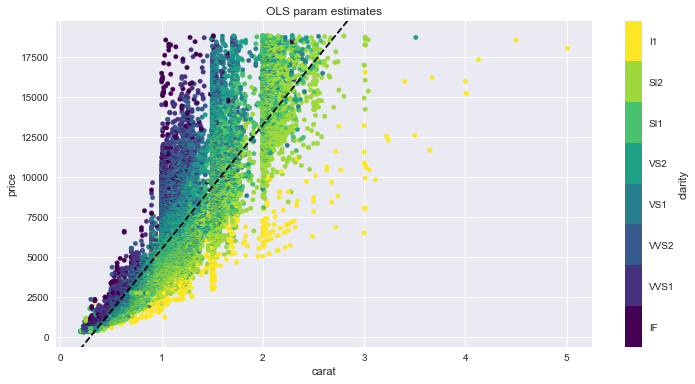

In [21]:
## OLS

fig, ax = plt.subplots(1,1,figsize=(12,6))
df.plot.scatter(y='price', x='carat', c='clarity', cmap='viridis', ax=ax)
ax.set(title='OLS param estimates', ylim=ax.get_ylim(), xlim=ax.get_xlim())

y, x = df.price, df[['const','carat']]

params = inv(x.T @ x) @ x.T @ y  ## beta = (X'X)^-1 X'Y
line(intercept=params[0], slope=params[1], ax=ax, linestyle='--', c='k')

print(f'b0={params[0]}\nb1={params[1]}')

b0=-2256.360580045401
b1=7756.425617968433
iter=252


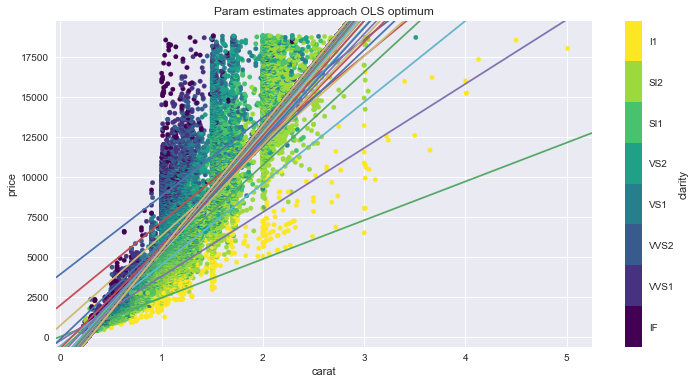

In [22]:
## General gradient descent method

# yield scatterplot of observations to depict gradual convergence
# using diamond prices in dollars, not ln(dollars), otherwise converges too quickly for demonstration
fig, ax = plt.subplots(1,1,figsize=(12,6))
df.plot.scatter(y='price', x='carat', c='clarity', cmap='viridis', ax=ax)
ax.set(title='Param estimates approach OLS optimum', ylim=ax.get_ylim(), xlim=ax.get_xlim())

b0 = b1 = 0
alpha = 1 / (2*len(y))        # learning rate (step size)
tolerence =  1E-8             # degree of precision desired, both derivatives must come this close to 0 
db0 = db1 = 1                 # init value to start while loop
loop_break = int(1E6)         # safety stop for loop, kill at X iterations
iter = 0                      # counter for iterations

y, x = df.price, df.carat

while abs(db0) > tolerence and abs(db1) > tolerence:
    db0 = -2*(y - (b1*x + b0)).sum()
    db1 = -2*(x*(y - (b1*x + b0))).sum()

    b0 -= alpha * db0
    b1 -= alpha * db1

    iter += 1

    if iter >= loop_break:
        print('Max iters reached, breaking loop')
        break

    if iter % 10:
        line(intercept=b0, slope=b1, ax=ax)

print(f'{b0=}\n{b1=}\n{iter=}')

## Newton-Raphson method:



In [482]:
## Newton method

b0 = b1 = 0
alpha = 1 / (2*len(y))        # learning rate (step size)
tolerence =  1E-9             # degree of precision desired, both derivatives must come this close to 0 
db0 = db1 = 1                 # init value to start while loop
loop_break = int(1E6)         # safety stop for loop, kill at X iterations
iter = 0                      # counter for iterations

def fd(y,x,beta):
    '''first derivative'''
    return  -2*(y * x).sum() + 2*beta*sum(x**2)

def sd(x):
    '''second derivative'''
    return 2 * (x**2).sum()

while db0 > tolerence and db1 > tolerence:
    beta_new = beta - fd(y,x,beta)/sd(x)
    gap = beta_new - beta
    beta = beta_new
    it += 1

#


beta = 7.726975499244868, number of iterations = 2


In [484]:
## Gradient descent

# 5000 epochs, try combinations of alpha and initial beta
# 5*5*5000 = 125,000 total iterations
# in python, x -= y is equivelant to x = x - y, etc.

y,x = df.ln_price, df.carat
niters = int(5E3)

for alpha in [1, 0.1, 0.01, 0.001]:        # try various alpha params
    for beta in [-5,-1,0,1,5]:             # try various initial beta guesses
        beta_i = beta                      # save initial beta value for log
        for i in range(niters):            # iterate through 5000 epochs
            beta -= alpha*fd(y,x,beta)/len(y)

        print(f'{alpha=}, initial beta = {beta_i}, final beta = {beta}')



alpha=1, initial beta = -5, final beta = 7.726975499244866
alpha=1, initial beta = -1, final beta = 7.726975499244866
alpha=1, initial beta = 0, final beta = 7.726975499244866
alpha=1, initial beta = 1, final beta = 7.726975499244866
alpha=1, initial beta = 5, final beta = 7.726975499244868
alpha=0.1, initial beta = -5, final beta = 7.726975499244865
alpha=0.1, initial beta = -1, final beta = 7.726975499244865
alpha=0.1, initial beta = 0, final beta = 7.726975499244865
alpha=0.1, initial beta = 1, final beta = 7.726975499244865
alpha=0.1, initial beta = 5, final beta = 7.726975499244865
alpha=0.01, initial beta = -5, final beta = 7.726975499244843
alpha=0.01, initial beta = -1, final beta = 7.726975499244843
alpha=0.01, initial beta = 0, final beta = 7.726975499244843
alpha=0.01, initial beta = 1, final beta = 7.726975499244843
alpha=0.01, initial beta = 5, final beta = 7.726975499244843
alpha=0.001, initial beta = -5, final beta = 7.724681842781127
alpha=0.001, initial beta = -1, fina

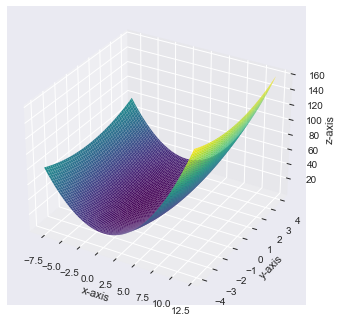

In [578]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')   # Create the axes

# Data
X = np.linspace(-8, 12, 200)
Y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2

# Plot the 3d surface
surface = ax.plot_surface(X, Y, Z,
                          cmap=cm.viridis,
                          rstride = 2,
                          cstride = 2)

# Set some labels
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

plt.show()

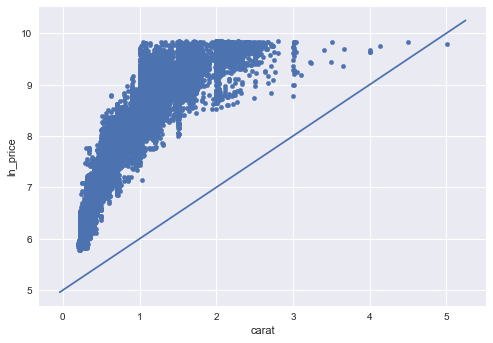

In [548]:
fig, ax = plt.subplots(1,1)


df.plot(kind='scatter', y='ln_price', x='carat', ax=ax)

line(slope=1, intercept=5, ax=ax)